# Predict tags on StackOverflow with linear models

Tags prediction for posts from [StackOverflow](https://stackoverflow.com).

### Libraries Used

- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data

The following cell will download all data required.

In [1]:
import sys
sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

File data\train.tsv is already downloaded.
File data\validation.tsv is already downloaded.
File data\test.tsv is already downloaded.
File data\text_prepare_tests.tsv is already downloaded.


### Text preprocessing

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sshar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sshar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [4]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [5]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [6]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [7]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

In [8]:
import re

## Text Cleaning

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text =BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join([word for word in text.split() if word not in STOPWORDS]) # delete stopwors from text
    text = text.strip()
    return text

Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [10]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

## Counting tags and words

In [11]:
from collections import Counter
tags_counts = Counter([item for taglist in y_train for item in taglist])
words_counts = Counter([word for line in X_train for word in line.split(' ')])

In [12]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print("most common tags are {} \n most common words are {}".format(most_common_tags,most_common_words))

most common tags are [('javascript', 19078), ('c#', 19077), ('java', 18661)] 
 most common words are [('using', 8278), ('php', 5614), ('java', 5501)]


### BOW

In [13]:
DICT_SIZE = 5000

INDEX_TO_WORDS = {key:item for key,item in enumerate(sorted(words_counts.keys(),key=lambda x:words_counts[x],reverse =True)[:DICT_SIZE])}
WORDS_TO_INDEX = {key:item for item,key in INDEX_TO_WORDS.items()}
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)

    for item in text.split():
        if item in words_to_index.keys():
            num = words_to_index[item]
            result_vector[num] += 1 
    return result_vector

In [14]:
from scipy import sparse as sp_sparse

In [15]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


#### TF-IDF



In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf = TfidfVectorizer(min_df=5,token_pattern = '\S+', max_df=0.9, ngram_range=(1, 3))

    X_train = tfidf.fit_transform(X_train)
    X_val = tfidf.transform(X_val)
    X_test = tfidf.transform(X_test)
    
    return X_train, X_val, X_test, tfidf.vocabulary_

In [18]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [19]:
tfidf_vocab['c++']

2129

### MultiLabel classifier



In [20]:
from sklearn.preprocessing import MultiLabelBinarizer

In [21]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [41]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier ,SGDClassifier

In [25]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    clf = OneVsRestClassifier(LogisticRegression(penalty='l1',solver='saga',max_iter = 500),n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf


Train the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

If you receive a convergence warning, please set parameter *max_iter* in LogisticRegression to a larger value (the default is 100).

In [26]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [55]:
y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

In [56]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_mybag)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(10):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	ruby,session


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails


Title:	library found
True labels:	c++,ios,iphone,xcode
Predicted labels:	


Title:	csproj file programmatic adding deleting files
True labels:	c#
Predicted labels:	


Title:	typeerror makedirs got unexpected keyword argument exists_ok
True labels:	django,python
Predicted labels:	python


Title:	pan div using jquery
True labels:	html,javascript,jquery
Predicted labels:	javascript,jquery


Title:	hibernate intermediate advanced tutorials
True labels:	hibernate,java
Pr

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 


In [57]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [58]:
def print_evaluation_scores(y_val, predicted):
    accuracy = accuracy_score(y_val,predicted)
    print(f1_score(y_val,predicted,average = 'samples'))
    print(roc_auc_score(y_val,predicted))
    print(average_precision_score(y_val,predicted))
    print(recall_score(y_val,predicted,average = 'samples'))

In [60]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
0.6243995815295814
0.7134604512636885
0.35563203784177
0.6019822222222222
Tfidf
0.6210142544492543
0.7058661393860934
0.34864590510789883
0.593231111111111


In [61]:
from metrics import roc_auc
%matplotlib inline

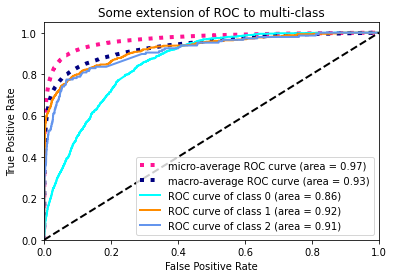

In [62]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

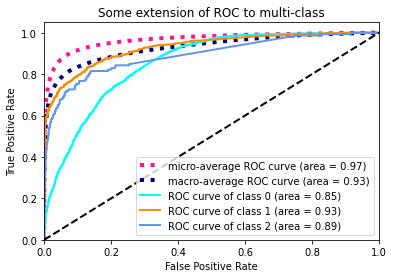

In [63]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

### MultilabelClassification

In [64]:
test_predictions = classifier_mybag.predict(X_test_mybag) 
test_pred_inversed = mlb.inverse_transform(test_predictions)

### Analysis of the most important features

In [65]:
classifier_mybag.estimators_[4].classes_

array([0, 1])

In [66]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    

    
    estimator = classifier.estimators_[tags_classes.index(tag)]
    coff = estimator.coef_[0]
    coff_idx = list(enumerate(coff))
    top_pos_words_idx = [idx for idx, wt in sorted(coff_idx, key=lambda x: x[1], reverse=True)[:5]]
    top_neg_words_idx = [idx for idx, wt in sorted(coff_idx, key=lambda x: x[1], reverse=False)[:5]]
    top_positive_words = [index_to_words[idx] for idx in top_pos_words_idx] # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[idx] for idx in top_neg_words_idx] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [67]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)

Tag:	c
Top positive words:	c, scanf, malloc, printf, fscanf
Top negative words:	php, javascript, java, python, c#

Tag:	c++
Top positive words:	c++, boost, qt, mfc, stdstring
Top negative words:	php, java, javascript, python, jquery

Tag:	linux
Top positive words:	linux, kernel space, signal, ubuntu, system call
Top negative words:	javascript, c#, jquery, array, aspnet

